# Factor-Based Analysis of Mutual Fund Data
This notebook demonstrates the process of analyzing mutual fund data using linear regression analysis against the Fama-French 6 factors.


In [ ]:
# Install required libraries (this is only necessary 
# if running in an environment that does not automatically handle 
# requirements.txt)
!pip install indiafactorlibrary


In [2]:
# Import Libraries
import pandas as pd
import statsmodels.formula.api as smf
from indiafactorlibrary import IndiaFactorLibrary


## Initialise IndiaFactorLibrary and Read Fama-French 6 Factors Dataset
We will initialise the `IndiaFactorLibrary` and read the Fama-French 6 factors dataset, which will be used in our regression analysis. The FF6 data is from Invespar "Data Library: Fama-French Factors, Momentum, and Low-Risk Factors for the Indian Market" available at https://www.invespar.com/research


In [3]:
# Initialize the IndiaFactorLibrary
ifl = IndiaFactorLibrary()

# Read the Fama-French 6 factors dataset
ff6 = ifl.read('ff6')[0]
print(ff6)


                MF    SMB5     HML     RMW     CMA     WML      RF     MKT
Dates                                                                     
2004-10-31  1.2168 -0.6080 -2.0792  2.3774 -2.8868  2.7795  0.3877  1.6045
2004-11-30  9.4784  3.3578  1.0583  4.5068 -1.6372  1.6852  0.4361  9.9145
2004-12-31  8.9490  4.3343  4.3104  2.0992  2.3392 -3.7736  0.4866  9.4356
2005-01-31 -1.9222  0.0250 -1.4563  1.9196 -1.0112  2.3761  0.4032 -1.5190
2005-02-28  3.2679  3.0760  4.7830 -1.3918 -0.8232  2.8335  0.4195  3.6874
...            ...     ...     ...     ...     ...     ...     ...     ...
2024-01-31  3.7383  4.8908  6.0960 -4.5838  3.2928  7.1994  0.5782  4.3165
2024-02-29  1.4083 -3.0371 -1.2132  0.1622  0.5138  1.1601  0.5838  1.9921
2024-03-31 -0.9468 -7.2897  0.2156  0.0868 -1.7741  1.0147  0.4921 -0.4547
2024-04-30  4.1428  7.2149  3.4824 -1.6815  0.8483  3.0944  0.5466  4.6894
2024-05-31  0.5197 -4.8571 -1.4302  1.7060  0.5262  1.0092  0.5777  1.0974

[236 rows x 8 columns]


## Factor Correlations 

In [4]:
print((ff6[['MF', 'SMB5','HML','RMW','CMA','WML']]/100).corr().round(2))

        MF  SMB5   HML   RMW   CMA   WML
MF    1.00  0.27  0.52 -0.45 -0.33 -0.35
SMB5  0.27  1.00  0.39 -0.25 -0.05 -0.22
HML   0.52  0.39  1.00 -0.70  0.15 -0.38
RMW  -0.45 -0.25 -0.70  1.00 -0.03  0.43
CMA  -0.33 -0.05  0.15 -0.03  1.00  0.20
WML  -0.35 -0.22 -0.38  0.43  0.20  1.00


## Fetch and Read the example file of Monthly Returns into a DataFrame
Read the Fund monthly returns into a pandas DataFrame.


In [5]:
# URL of the CSV file on GitHub
url = 'https://raw.githubusercontent.com/rraju26/pyIndiaFactorInvesting/main/data/fba_sample_data.csv'

# Local file path
file_path = 'data/fba_sample_data.csv'

# Try to read the CSV file from the local directory, fallback to URL if it fails
try:
    fund_returns = pd.read_csv(file_path, index_col='Dates', parse_dates=['Dates'])
except FileNotFoundError:
    fund_returns = pd.read_csv(url, index_col='Dates', parse_dates=['Dates'])

print(fund_returns.head(10))

            sample_fund
Dates                  
2013-01-31       -0.745
2013-02-28       -2.495
2013-03-31        1.631
2013-04-30        6.336
2013-05-31        4.082
2013-06-30       -3.347
2013-07-31        0.066
2013-08-31       -4.204
2013-09-30        6.615
2013-10-31        7.126


## Calculate Monthly Returns and Excess Returns
We will calculate the monthly returns and excess returns by:
1. Calculating monthly returns, dropping NaN values, and converting to percentages.
2. Subtracting the risk-free rate from the FF Dataset to get excess returns, and dropping NaN values.


In [6]:
# Subtract risk-free rate to get excess returns, and drop NaN values
fund_returns_excess = fund_returns.sub(ff6['RF'], axis=0).dropna()
print('Excess Returns:')
print(fund_returns_excess.head(10))


Excess Returns:
            sample_fund
Dates                  
2013-01-31      -1.4736
2013-02-28      -3.1243
2013-03-31       1.0260
2013-04-30       5.7185
2013-05-31       3.4392
2013-06-30      -3.9324
2013-07-31      -0.6805
2013-08-31      -5.0780
2013-09-30       5.7755
2013-10-31       6.3811


## Concatenate Excess Returns with Fama-French 6 Factors Dataset
We will concatenate the excess returns with the Fama-French 6 factors dataset.


In [7]:
# Concatenate excess returns with Fama-French 6 factors dataset
fund_df = pd.concat([fund_returns_excess, ff6[['MF', 'SMB5', 'HML', 'RMW', 'CMA', 'WML']]], axis=1).dropna()
print(fund_df)

            sample_fund      MF    SMB5      HML     RMW     CMA     WML
Dates                                                                   
2013-01-31      -1.4736  0.7448 -3.1895  -4.2488  1.0954 -0.0078 -2.2946
2013-02-28      -3.1243 -7.5909 -3.8411  -8.1948  5.1298 -2.6902  2.4837
2013-03-31       1.0260 -2.7063 -3.9798  -3.8876  6.9282 -4.3362  4.0490
2013-04-30       5.7185  3.4903 -0.5365   1.8054 -4.2462  3.7902  0.5470
2013-05-31       3.4392  0.0382 -0.3801 -10.6470  2.7881 -1.4588  6.2380
...                 ...     ...     ...      ...     ...     ...     ...
2024-01-31       6.1928  3.7383  4.8908   6.0960 -4.5838  3.2928  7.1994
2024-02-29       2.9112  1.4083 -3.0371  -1.2132  0.1622  0.5138  1.1601
2024-03-31       0.5099 -0.9468 -7.2897   0.2156  0.0868 -1.7741  1.0147
2024-04-30       7.1074  4.1428  7.2149   3.4824 -1.6815  0.8483  3.0944
2024-05-31      -4.1237  0.5197 -4.8571  -1.4302  1.7060  0.5262  1.0092

[137 rows x 7 columns]


## Perform Linear Regression and Print Summary
We will perform a linear regression analysis using the excess returns and Fama-French 6 factors and print the regression summary. We fit a standard model here, but for the real world, we suggest corrections to deal with the auto-correlation inherent in financial time series.


In [8]:
# Perform linear regression using statsmodels
regression = smf.ols('sample_fund ~ MF + SMB5 + HML + RMW + CMA + WML', data=fund_df / 100).fit()

# Print the regression summary
print(regression.summary())


                            OLS Regression Results                            
Dep. Variable:            sample_fund   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     167.1
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           1.37e-58
Time:                        23:43:05   Log-Likelihood:                 369.11
No. Observations:                 137   AIC:                            -724.2
Df Residuals:                     130   BIC:                            -703.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0028      0.002      1.795      0.0

## A Multicollinearity Check
The explanatory variables might be highly correlated, affecting coefficient accuracy. We have already examined the correlations and noted the higher correlations between HML and RMW.

A further test is the Variance Inflation Factor test. This is a widely used method that calculates a score for each independent variable. A VIF of 1 indicates no multicollinearity, while values greater than 5 (or sometimes 10) suggest potential issues.
Higher VIF values imply an independent variable can be largely explained by a linear combination of other independent variables, making its individual coefficient estimate less reliable. Most statistical software packages can calculate VIFs.


In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Extract the independent variables from the fitted model
X = fund_df[['MF', 'SMB5', 'HML','RMW','CMA','WML']]/100
#calculate VIF for each explanatory variable
vifs = pd.DataFrame([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                   index=[X.columns], columns=['VIF'])

print(vifs.round(2))

       VIF
MF    1.71
SMB5  1.38
HML   3.36
RMW   2.35
CMA   1.33
WML   1.26


## Plot Residuals

<Axes: xlabel='Dates'>

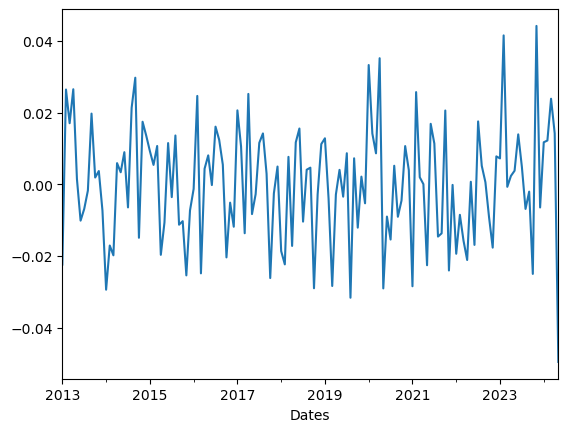

In [10]:
regression.resid.plot()

# References
1. Fama, E. F., & French, K. R. (1993). Common risk factors in the returns on stocks and bonds. *Journal of Financial Economics, 33*(1), 3-56.
2. Carhart, M. M. (1997). On persistence in mutual fund performance. *The Journal of Finance, 52*(1), 57-82.
3. Fama, E. F., & French, K. R. (2015). A five-factor asset pricing model. *Journal of Financial Economics, 116*(1), 1-22.
4. Raju, R. (2022). Four and Five-Factor Models in the Indian Equities Market. *SSRN eLibrary*, March, 37
5. Raju, R. (2022), A Five-Factor Asset Pricing Model: Preliminary Evidence from India, *SSRN eLibrary*, August, 33
6. Factor Data sourced from [Invespar Data Library: Data Library: Fama-French Factors, Momentum, and Low-Risk Factors for the Indian Market](http://invespar.com/research).